## The parameter-shift rule

Given a variational circuit $U(\theta)$ composed of parameterized Pauli rotations, and some measured observable $\hat{B}$, the derivative of the expectation value

$$
\langle\hat{B}\rangle(\boldsymbol{\theta})=\left\langle 0\left|U(\boldsymbol{\theta})^{\dagger} \hat{B} U(\boldsymbol{\theta})\right| 0\right\rangle
$$

with respect to the input circuit parameters $\theta$ is given by

$$
\nabla_{\theta_i}\langle\hat{B}\rangle(\boldsymbol{\theta})=\frac{1}{2}\left[\langle\hat{B}\rangle\left(\boldsymbol{\theta}+\frac{\pi}{2} \hat{\mathbf{e}}_i\right)-\langle\hat{B}\rangle\left(\boldsymbol{\theta}-\frac{\pi}{2} \hat{\mathbf{e}}_i\right)\right] .
$$

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
dev = qml.device("default.qubit", wires=3)

In [4]:
qml.drawer.use_style("sketch")

In [5]:
@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    
    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [6]:
# initial parameters
params = np.random.random([6], requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871566


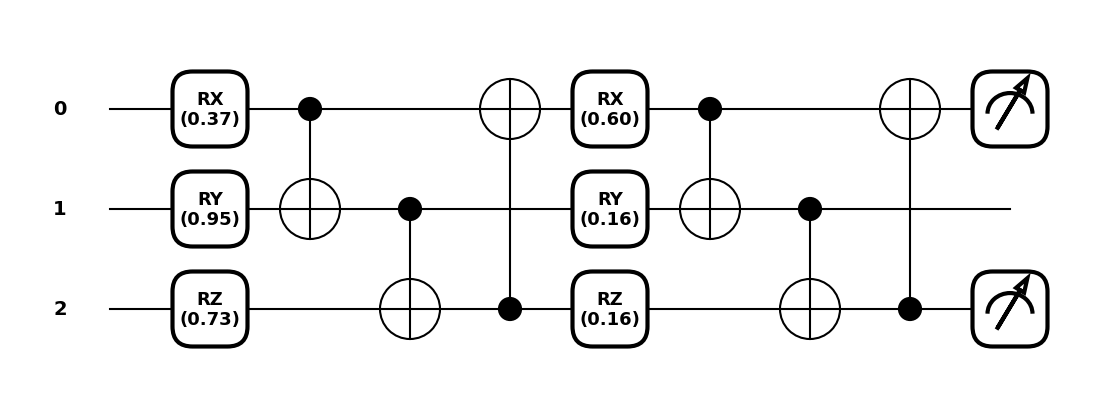

In [7]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [8]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi / 2
    forward = qnode(shifted)
    
    shifted[i] -= np.pi
    backward = qnode(shifted)
    
    return 0.5 * (forward - backward)

In [9]:
print(parameter_shift_term(circuit, params, 0))

-0.06518877224958122


In [10]:
grad_function = qml.grad(circuit) # built-in
print(grad_function(params)[0])

-0.06518877224958124


In [11]:
print(qml.gradients.param_shift(circuit)(params))

(array(-0.06518877), array(-0.02728919), array(-2.77555756e-17), array(-0.09339346), array(-0.76106757), array(4.16333634e-17))


## Reverse mode vs Parameter-shift

In [12]:
dev = qml.device("default.qubit", wires=4)

In [13]:
@qml.qnode(dev, diff_method='parameter-shift', interface='autograd')
def circuit_1(params):
    qml.StronglyEntanglingLayers(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

@qml.qnode(dev, diff_method='backprop', interface='autograd')
def circuit_2(params):
    qml.StronglyEntanglingLayers(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [14]:
# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

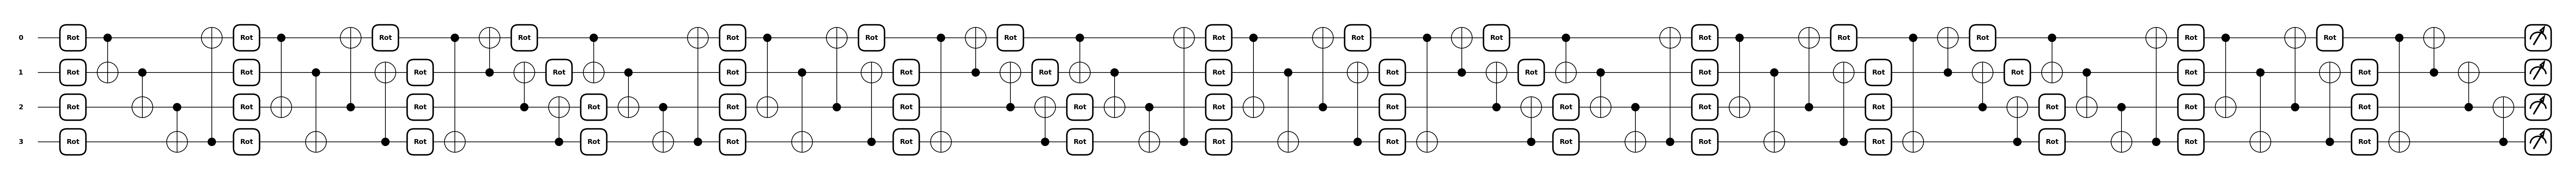

In [16]:
qml.draw_mpl(circuit_1)(params)
plt.show()

In [17]:
import timeit

In [19]:
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=depth)
    params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
    num_params = params.size

    # forward pass timing
    # ===================
    # parameter-shift
    t = timeit.repeat("circuit_1(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("circuit_2(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============
    # parameter-shift
    t = timeit.repeat("qml.grad(circuit_1)(params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qml.grad(circuit_2)(params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

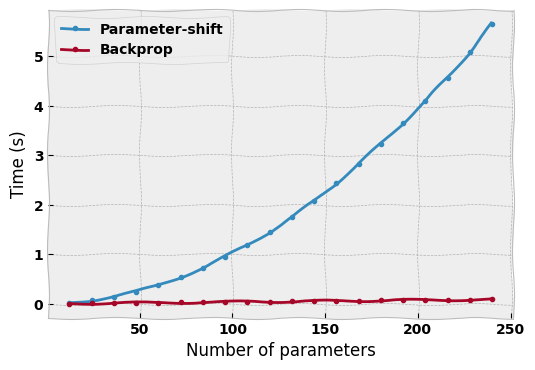

In [20]:
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

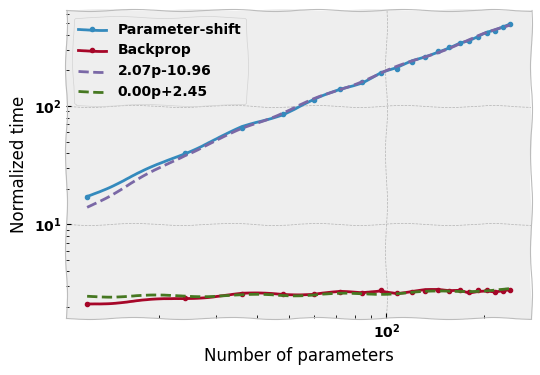

In [21]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")

# perform a least squares regression to determine the linear best fit/gradient
# for the normalized time vs. number of parameters
x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg=1)
m_back, c_back = np.polyfit(*gradient_backprop, deg=1)

ax.plot(x, m_shift * x + c_shift, '--', label=f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label=f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()